# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import r2_score, mean_squared_error
from time import time
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
# classifiers
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
# performance metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.datasets import make_multilabel_classification
# model saving 
import pickle

%matplotlib inline

In [2]:
# read in the json files
#portfolio = pd.read_json('data/portfolio.json',dtype={'channels':str, 'difficulty':float, 'duration':float, 'id':str, 'offer_type':str, 'reward':float}, orient='records', lines=True)
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
profile.shape

(17000, 5)

# Lets examine the data sets

In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [10]:
indicies_age118 = profile[profile['age']==118].index.values
indicies_age118.shape

(2175,)

In [11]:
profile.drop(indicies_age118, axis=0).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 14825 non-null int64
id                  14825 non-null object
became_member_on    14825 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


#### There are several users that have not entered any profile data for age, gender, and income.  Therefore, we may want to disclude them from certain analysis

In [12]:
def gender_income_vs_age(g):
    '''Function to plot average income vs age
    Args:
        g (str): gender ()
    Returns:
    '''
    # fit and fill male income
    gender = profile[profile['gender']==g]
    
    #age_income = gender[gender['age']!=118].groupby('age')['income'].mean().reindex()
    # offer_received_counts = offers_received.groupby('offer_id')['offer_id'].agg([('received_count','count')]).reset_index()
    age_income = gender.groupby('age')['income'].agg([('average_income', 'mean'), ('STDDEV', 'std')]).reset_index()
    
    age = age_income['age'].values
    average_income =  age_income['average_income'].values
    std = age_income['STDDEV'].values
    
    #plt.plot(age, average_income, 'o')
    
    g_dict = {'M':'Male', 'F':'Female', 'O':'Other Gender'}
    
    plt.errorbar(age, average_income, yerr=std, color='k', lw=3,  ecolor='b')
    plt.xlabel('Age')
    title = f'Average {g_dict[g]} Income'
    plt.ylabel('Average Income')
    plt.title(title)

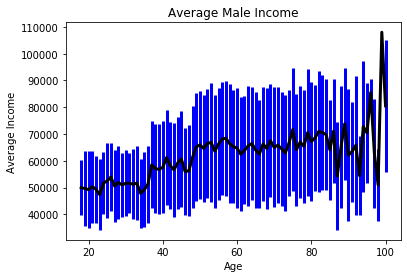

In [13]:
gender_income_vs_age('M')

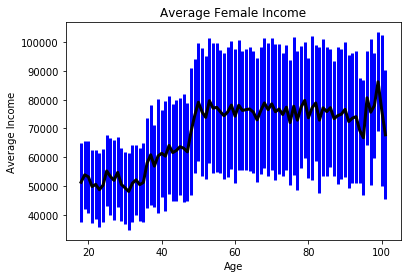

In [14]:
gender_income_vs_age('F')

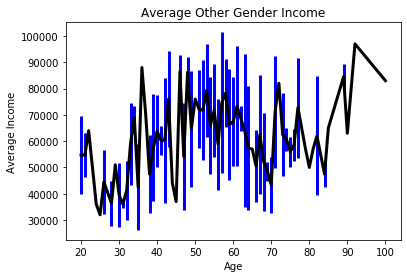

In [15]:
gender_income_vs_age('O')

In [16]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [17]:
transcript.dtypes

person    object
event     object
value     object
time       int64
dtype: object

In [18]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


# Convert to Usable Datatypes

### portfolio
#### 'channels' contain lists of strings that need to be expanded as categorical variables

In [19]:
channel_types = []
for _, row in portfolio.iterrows():
    for channel in row['channels']:
        channel_types.append(channel)
        
channel_types=list((set(channel_types)))
channel_types
    

for channel_type in channel_types:
    portfolio[channel_type] = portfolio['channels'].apply(lambda x: (channel_type in x)*1)
    
portfolio.drop('channels', axis=1, inplace=True)

### convert duration to hours so it is consistent with other time values

In [20]:
portfolio['duration_in_hours'] = portfolio['duration']*24
['difficulty', 'duration', 'bogo', 'discount', 'reward', 'web', 'mobile', 'social', 'duration_in_hours']

['difficulty',
 'duration',
 'bogo',
 'discount',
 'reward',
 'web',
 'mobile',
 'social',
 'duration_in_hours']

In [21]:
portfolio.head()

,reward,difficulty,duration,offer_type,id,web,email,social,mobile,duration_in_hours
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,168
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,120
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,96
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,168
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,240


### profile
#### 'became_member_on' needs to be converted to a datetime 



In [22]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y/%m/%d')

In [23]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,1970-01-01 00:00:00.020170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,1970-01-01 00:00:00.020180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,1970-01-01 00:00:00.020170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,1970-01-01 00:00:00.020170804,NaN


### trancript
#### data stored in the 'value column' needs to be expanded categorically


In [24]:
d_keys = []

for _, row in transcript.iterrows():
    for key in list(row['value'].keys()):
        d_keys.append(key)
    
d_keys = set(d_keys)

print(d_keys)

for key in d_keys:
    transcript[key]=transcript['value'].apply(lambda x: x[key] if key in x else None)
    
transcript.drop('value', axis=1, inplace=True)
    

{'reward', 'offer id', 'offer_id', 'amount'}


In [25]:
amount_indecies = transcript[transcript['amount'].notnull()].index.values
noamount_indicies = transcript[transcript['amount'].isnull()].index.values
reward_indicies = transcript[transcript['reward'].notnull()].index.values

In [26]:
transcript.loc[reward_indicies].head()

,person,event,time,reward,offer id,offer_id,amount
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2.0,None,2906b810c7d4411798c6938adc9daaa5,NaN
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,2.0,None,fafdcd668e3743c1bb461111dcafc2a4,NaN
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,5.0,None,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,10.0,None,ae264e3637204a6fb9bb56bc8210ddfd,NaN
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,10.0,None,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [27]:
transcript.loc[amount_indecies].head()

,person,event,time,reward,offer id,offer_id,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,NaN,None,None,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,NaN,None,None,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,NaN,None,None,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,NaN,None,None,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,NaN,None,None,18.97


In [28]:
transcript.loc[noamount_indicies].head()

,person,event,time,reward,offer id,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,None,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,None,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,None,NaN


In [29]:
transcript.dtypes

person       object
event        object
time          int64
reward      float64
offer id     object
offer_id     object
amount      float64
dtype: object

In [30]:
t1 = transcript[transcript['offer id'].notnull()]
t1.head()

,person,event,time,reward,offer id,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,None,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,None,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,None,NaN


In [31]:
t2 = transcript[transcript['offer_id'].notnull()]
t2.head()

,person,event,time,reward,offer id,offer_id,amount
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2.0,None,2906b810c7d4411798c6938adc9daaa5,NaN
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,2.0,None,fafdcd668e3743c1bb461111dcafc2a4,NaN
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,5.0,None,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,10.0,None,ae264e3637204a6fb9bb56bc8210ddfd,NaN
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,10.0,None,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


### We can see that the transcript data has two different values that should be 1 column, 'offer id' and 'offer_id' so we need to make a new column that has all offer_ids

In [32]:
transcript = transcript.rename(columns={'offer id':'o1_id', 'offer_id':'o2_id'})

In [33]:
transcript.head()

,person,event,time,reward,o1_id,o2_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,None,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,None,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,None,NaN


In [34]:
def get_offer_id(row):
    if row['o1_id']:
        return row['o1_id']
    elif row['o2_id']:
        return row['o2_id']
    else:
        return None

In [35]:
transcript['offer_id'] = transcript.apply(get_offer_id, axis=1)

In [36]:
transcript.head(2)

,person,event,time,reward,o1_id,o2_id,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [37]:
transcript.drop(['o1_id', 'o2_id'], axis=1, inplace=True)

In [38]:
events = set(transcript['event'])
total_count = 0
for event in events:
    count = transcript[transcript['event']==event].shape[0]
    print(transcript[transcript['event']==event].head(1).to_string())
    total_count += count
    print(f'{event}: {count}')

                                 person            event  time  reward  amount                          offer_id
12658  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  offer completed     0     2.0     NaN  2906b810c7d4411798c6938adc9daaa5
offer completed: 33579
                             person           event  time  reward  amount                          offer_id
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0     NaN     NaN  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer received: 76277
                                 person        event  time  reward  amount offer_id
12654  02c083884c7d45b39cc68e1314fec56c  transaction     0     NaN    0.83     None
transaction: 138953
                                 person         event  time  reward  amount                          offer_id
12650  389bc3fa690240e798340f5a15918d5c  offer viewed     0     NaN     NaN  f19421c1d4aa40978ebb69ca19b0e20d
offer viewed: 57725


## Now we have merged 'offer_id' and 'offer id' into a single column and we can begin to explore the data

### Lets look at a simple description of each dataframe

In [39]:
portfolio.describe()

,reward,difficulty,duration,web,email,social,mobile,duration_in_hours
count,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000,0.800000,1.0,0.600000,0.900000,156.000000
std,3.583915,5.831905,2.321398,0.421637,0.0,0.516398,0.316228,55.713553
min,0.000000,0.000000,3.000000,0.000000,1.0,0.000000,0.000000,72.000000
25%,2.000000,5.000000,5.000000,1.000000,1.0,0.000000,1.000000,120.000000
50%,4.000000,8.500000,7.000000,1.000000,1.0,1.000000,1.000000,168.000000
75%,5.000000,10.000000,7.000000,1.000000,1.0,1.000000,1.000000,168.000000
max,10.000000,20.000000,10.000000,1.000000,1.0,1.000000,1.000000,240.000000


In [40]:
profile.describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


In [41]:
transcript.describe()

,time,reward,amount
count,306534.000000,33579.000000,138953.000000
mean,366.382940,4.904137,12.777356
std,200.326314,2.886647,30.250529
min,0.000000,2.000000,0.050000
25%,186.000000,2.000000,2.780000
50%,408.000000,5.000000,8.890000
75%,528.000000,5.000000,18.070000
max,714.000000,10.000000,1062.280000


### Lets check some distribtions within our profile data

In [42]:
def gender_income_vs_age(g):
    '''Function to plot average income vs age
    Args:
        g (str): gender ()
    Returns:
    '''
    # fit and fill male income
    gender = profile[profile['gender']==g]
    
    #age_income = gender[gender['age']!=118].groupby('age')['income'].mean().reindex()
    # offer_received_counts = offers_received.groupby('offer_id')['offer_id'].agg([('received_count','count')]).reset_index()
    age_income = gender.groupby('age')['income'].agg([('average_income', 'mean'), ('STDDEV', 'std')]).reset_index()
    
    age = age_income['age'].values
    average_income =  age_income['average_income'].values
    std = age_income['STDDEV'].values
    
    #plt.plot(age, average_income, 'o')
    
    g_dict = {'M':'Male', 'F':'Female', 'O':'Other Gender'}
    
    plt.errorbar(age, average_income, yerr=std, color='k', lw=3,  ecolor='b')
    plt.xlabel('Age')
    title = f'Average {g_dict[g]} Income'
    plt.ylabel('Average Income')
    plt.title(title)

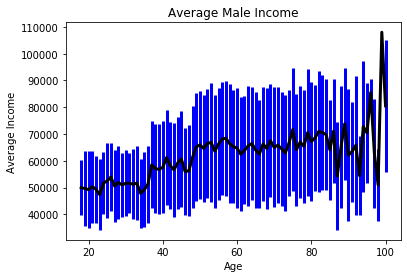

In [43]:
gender_income_vs_age('M')

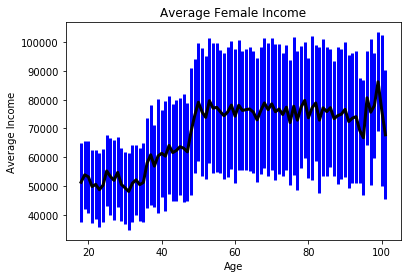

In [44]:
gender_income_vs_age('F')

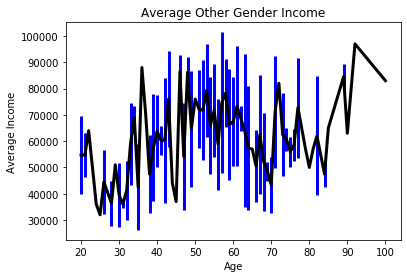

In [45]:
gender_income_vs_age('O')

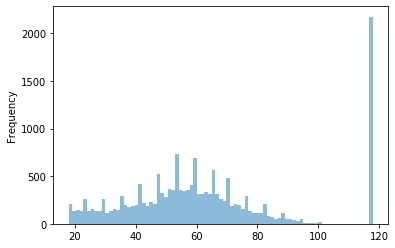

In [46]:
profile['age'].plot.hist(bins=83, alpha=0.5)


### We can see that after removing the users with age 118, the max user age is 101 and the average user age is 54.  We can also see an approximate normal distribution which is slightly skewed to have more users in the low age range than in the high age range.

In [47]:
set(profile['gender'])

{'F', 'M', None, 'O'}

In [48]:
profile['gender'].fillna('N', inplace=True)

In [49]:
profile[profile['gender']=='N'].shape

(2175, 5)

### We have 4 different types of genders: female, male, other, not given

genders: ['F' 'M' 'N' 'O']
gender_counts: [6129 8484 2175  212]


Text(0.5, 0, 'Gender')

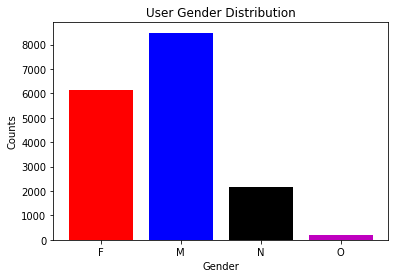

In [50]:
# Lets examine the gender distribution of the users
gender_count = profile.groupby('gender')['gender'].count()

genders = gender_count.index.values
gender_counts = gender_count.values
print(f'genders: {genders}')
print(f'gender_counts: {gender_counts}')
plt.bar(genders, gender_counts, color =('r', 'b', 'k', 'm'))
plt.title('User Gender Distribution')
plt.ylabel('Counts')
plt.xlabel('Gender')

### We can see here tht there are more male users than female users.  We can also see that there are 212 users that do not identify as male or female.

### Lets examine the age distribution of the users by gender

Text(0.5, 1.0, 'Male Age Distribution')

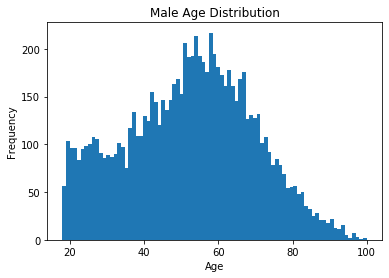

In [51]:
ax = profile[profile['gender']=='M']['age'].plot.hist(bins=83)
ax.set_xlabel('Age')
ax.set_title('Male Age Distribution')

Text(0.5, 1.0, 'Female Age Distribution')

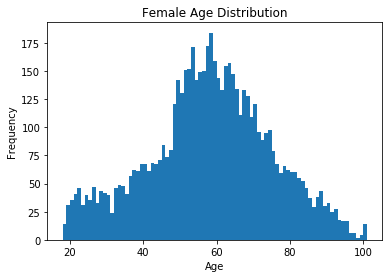

In [52]:
ax = profile[profile['gender']=='F']['age'].plot.hist(bins=83)
ax.set_xlabel('Age')
ax.set_title('Female Age Distribution')

Text(0.5, 1.0, 'Other Gender Age Distribution')

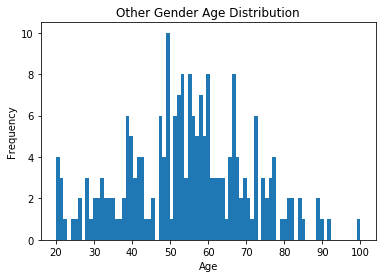

In [53]:
ax =profile[profile['gender']=='O']['age'].plot.hist(bins=83)
ax.set_xlabel('Age')
ax.set_title('Other Gender Age Distribution')

### We can see that a higher pecentage of the male users fall in the 20-40 year range than the female users.  We can also see that there are only 212 'other' gender users and therfore, we do not have a large enough sample size for this subgroup to get a filled normal distribution in age.  There are 2175 users that have not entered any of their profile information.  This is a large portion of the total user base and we will not want to disclude them when analyzing transactions, but we will need to be clever in dealing with this users when making machine learning features. 

# Rename columns to have more meaning

In [54]:
portfolio.columns

Index(['reward', 'difficulty', 'duration', 'offer_type', 'id', 'web', 'email',
       'social', 'mobile', 'duration_in_hours'],
      dtype='object')

In [55]:
portfolio = portfolio.rename(columns={'id':'offer_id', 'reward':'offer_reward'})

In [56]:
portfolio.columns

Index(['offer_reward', 'difficulty', 'duration', 'offer_type', 'offer_id',
       'web', 'email', 'social', 'mobile', 'duration_in_hours'],
      dtype='object')

In [57]:
portfolio.head()

,offer_reward,difficulty,duration,offer_type,offer_id,web,email,social,mobile,duration_in_hours
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,168
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,120
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,96
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,168
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,240


In [58]:
profile.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income'], dtype='object')

In [59]:
profile = profile.rename(columns={'id':'user_id'})

In [60]:
profile.columns

Index(['gender', 'age', 'user_id', 'became_member_on', 'income'], dtype='object')

In [61]:
transcript.columns

Index(['person', 'event', 'time', 'reward', 'amount', 'offer_id'], dtype='object')

In [62]:
transcript = transcript.rename(columns={'person':'user_id', 'amount':'transaction_amount', 'reward':'rewarded'})

In [63]:
transcript.columns

Index(['user_id', 'event', 'time', 'rewarded', 'transaction_amount',
       'offer_id'],
      dtype='object')

# Lets do some exploritory data analysis to examine the spending habits of the users

In [64]:
def get_user_spending(transcript, profile, portfolio):
    '''Function that examines aggreagate spending habbits of users
    Args:
        transcript (df): df with events
        portfolio (df): df with offer information
    Returns:
        user_spending (df): df with user spending habbits
    '''

    user_spending = pd.DataFrame()
    # total spending by user
    total_spending = transcript.groupby('user_id')['transaction_amount'].sum()
    user_spending['user_id'] = total_spending.index.values
    user_spending['total_spending'] = total_spending.values
    user_spending.fillna(0, inplace=True)

    # total transaction count
    user_spending['transaction_count'] = transcript.groupby('user_id')['transaction_amount'].count().values
    user_spending.fillna(0, inplace=True)

    # average transaction amount
    user_spending['average_transaction'] = user_spending['total_spending']/user_spending['transaction_count'] 

    # total offers received
    offers = transcript[transcript['event']=='offer received'].groupby('user_id')['event'].count()
    offers_received = pd.DataFrame({'user_id':offers.index.values, 'offers_received':offers.values})
    user_spending = user_spending.merge(offers_received, how='left', on='user_id')
    user_spending.fillna(0, inplace=True)

    # total offers viewed
    views = transcript[transcript['event']=='offer viewed'].groupby('user_id')['event'].count()
    offers_viewed = pd.DataFrame({'user_id':views.index.values, 'offers_viewed':views.values})
    user_spending = user_spending.merge(offers_viewed, how='left', on='user_id')
    user_spending.fillna(0, inplace=True)

    # view rate
    user_spending['view_rate'] = user_spending['offers_viewed']/user_spending['offers_received']

    # total offers completed
    completions = transcript[transcript['event']=='offer completed'].groupby('user_id')['event'].count()
    offers_completed = pd.DataFrame({'user_id':completions.index.values, 'offers_completed':completions.values})
    user_spending = user_spending.merge(offers_completed, how='left', on='user_id')
    user_spending.fillna(0, inplace=True)
    
    # completion_rate
    user_spending['completion_rate'] = user_spending['offers_completed']/user_spending['offers_received']
    
    user_spending.fillna(0, inplace=True)
    
    user_spending = user_spending.merge(profile, how='left', on='user_id')
    
    return user_spending

user_spending = get_user_spending(transcript, profile, portfolio)


In [65]:
user_spending.columns

Index(['user_id', 'total_spending', 'transaction_count', 'average_transaction',
       'offers_received', 'offers_viewed', 'view_rate', 'offers_completed',
       'completion_rate', 'gender', 'age', 'became_member_on', 'income'],
      dtype='object')

In [66]:
def plot_avergae_w_error(df, x_col, y_col, y_err_col, plot_title, x_label,  y_label):
    '''Function to make x-y line plot with error bars
    Args:
        df (df): df 
        x_col (str): col for x axis
        y_col (str): col for y axis
        y_err_col: col for y error bars
        plot_title (str): plot title
        x_label (str): x axis label
        y_label (str): y axis label
    Returns:
        None
    '''
    plt.figure()
    plt.errorbar(df[x_col].values, df[y_col].values, yerr=df[y_err_col].values, 
                      color='k', lw=3,  ecolor='b')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)


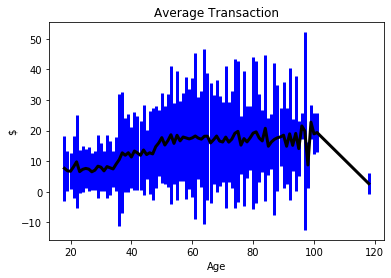

In [67]:
average_transaction_df = user_spending.groupby('age')['average_transaction'].agg(
    [('average_transaction', 'mean'), ('STDDEV', 'std')]).reset_index()

plot_avergae_w_error(average_transaction_df, 'age', 'average_transaction', 'STDDEV', 'Average Transaction', 'Age',  '$')

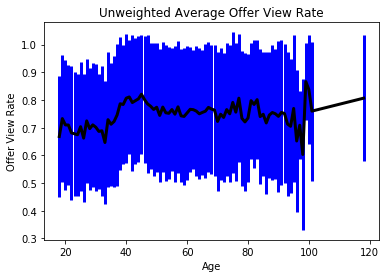

In [68]:
average_view_rate = user_spending.groupby('age')['view_rate'].agg(
    [('average_view_rate', 'mean'), ('STDDEV', 'std')]).reset_index()

plot_avergae_w_error(average_view_rate, 'age', 'average_view_rate', 'STDDEV', 'Unweighted Average Offer View Rate', 'Age',  'Offer View Rate')


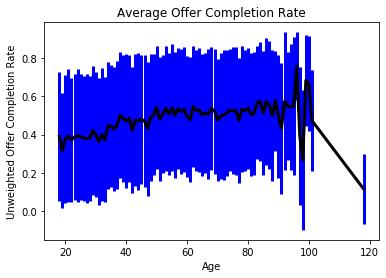

In [69]:
average_completion_rate_df = user_spending.groupby('age')['completion_rate'].agg(
    [('average_completion_rate', 'mean'), ('STDDEV', 'std')]).reset_index()

plot_avergae_w_error(average_completion_rate_df, 'age', 'average_completion_rate', 'STDDEV',
                     'Average Offer Completion Rate', 'Age',  'Unweighted Offer Completion Rate')

###  It is also hard to see any aparent trends in these plots due to the high variability of the data.

In [70]:
user_spending.columns

Index(['user_id', 'total_spending', 'transaction_count', 'average_transaction',
       'offers_received', 'offers_viewed', 'view_rate', 'offers_completed',
       'completion_rate', 'gender', 'age', 'became_member_on', 'income'],
      dtype='object')

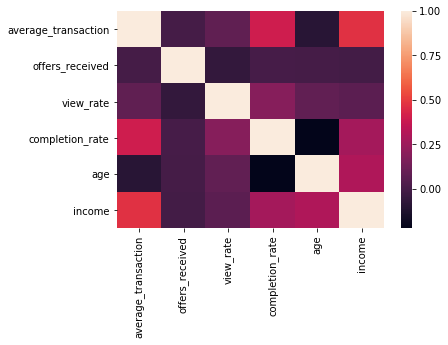

In [71]:
# create a correlation heatmap to examine the correlation of user attributes to spending behavior
corr = user_spending[['average_transaction','offers_received', 
                      'view_rate','completion_rate', 'gender', 
                      'age', 'income']].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### We can see that users who make more money are likely to spend more money.  We can also see that offers are more likely to be completed if they are viewed.  Unsuprisingly, users that spend more in a single transaction are more likely to complete an offer.

## Lets look at some user spending data

In [72]:
# get offers received, viewed, and completed
offers_received = transcript[transcript['event']=='offer received'].drop(['rewarded', 'transaction_amount'], axis=1)
offers_received['received_time'] = offers_received['time']
# add a received id for later use to make sure each received offer only has one end state 
#    [viewed, viewed_completed, completed_not_viewed, or ignored]
offers_received['received_id'] = offers_received.reset_index().index.values


offers_viewed = transcript[transcript['event']=='offer viewed'].drop(['rewarded', 'transaction_amount'], axis=1)
offers_viewed['viewed_time'] = offers_viewed['time']
offers_viewed['viewed_id'] = offers_viewed.reset_index().index.values

offers_completed = transcript[transcript['event']=='offer completed'].drop(['rewarded', 'transaction_amount'], axis=1)
offers_completed['completed_time'] = offers_completed['time']

In [73]:
offers_received.head()

,user_id,event,time,offer_id,received_time,received_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,2
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,3
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,4


In [74]:
offers_received.shape

(76277, 6)

In [75]:
offers_received.duplicated().sum()

0

In [76]:
offers_viewed.shape

(57725, 6)

In [77]:
offers_viewed.duplicated().sum()

0

In [78]:
offers_completed.shape

(33579, 5)

In [79]:
offers_completed[['user_id', 'offer_id', 'completed_time']].duplicated().sum()

397

# We have duplicates of completed offers, these will need to be handled carefully when merging dataframes

In [81]:
offers_completed = offers_completed[['user_id', 'offer_id', 'completed_time']].drop_duplicates()

In [82]:
offers_completed['completed_id'] = offers_completed.reset_index().index.values

In [83]:
offers_completed.shape

(33182, 4)

In [84]:
offers_viewed.shape

(57725, 6)

In [85]:
profile.shape

(17000, 5)

In [86]:
profile.duplicated().sum()

0

In [87]:
# convert 'duration' to hours so that we can have the same time units for all event handling
portfolio['duration_in_hours'] = portfolio['duration']*24
portfolio

,offer_reward,difficulty,duration,offer_type,offer_id,web,email,social,mobile,duration_in_hours
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,168
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,120
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,96
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,168
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,240
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,168
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,240
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,72
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,120
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,168


In [88]:
# offers_received.columns
offers_received['received_id'].duplicated().sum()

0

In [89]:
completable_offers = portfolio[portfolio['offer_type']!='informational']['offer_id'].tolist()

In [90]:
def get_rv_df(offers_received, offers_viewed, portfolio):
    '''Function to return dataframe with all offers that have been viewed, including informational
    Args:
        offers_received (df): df with offers recieved, columns 
            ['event', 'user_id', 'received_time', 'offer_id']
        offers_viewed (df): df with offers recieved, columns 
            ['event', 'user_id', 'viewed_time', 'offer_id']
    Returns:
        rv_df (df): df with the intersection of offers viewed and received columns
            ['user_id', 'viewed_time', 'offer_id', 'received_time', 'time_to_view',
           'difficulty', 'duration', 'offer_type', 'offer_reward', 'social',
           'email', 'web', 'mobile']
    '''
    # if users have received the same offer multiple times, we will need to match up views to received offers
    # make sure timing is correctly aligned, so that each offer is only viewed once if a user receives and view 
    # the same offer multiple times within the offer duration
    rv_df = pd.merge_asof(offers_viewed, offers_received,on='time', direction='backward',by=['user_id', 'offer_id'])
    rv_df['time_to_view'] = rv_df['viewed_time']-rv_df['received_time']
    
    # make sure all viewed offers have been included
    assert(offers_viewed.shape[0]==rv_df.shape[0])
    # make sure no time missalignment where viewed time is before received time
    assert(rv_df[rv_df['time_to_view']<0].shape[0] == 0)
    # make sure there are no dupolicates, ie. multiple viewed_times merged to the same recieved time
    assert(rv_df[['user_id', 'offer_id', 'received_time']].duplicated().sum()==0)
    # make sure there are no duplicates of viewed_id and received_id, each offer can only be received and viewed once
    assert(rv_df.merge(offers_viewed, how='inner', on='viewed_id').shape[0]==rv_df.shape[0])
    assert(rv_df['viewed_id'].duplicated().sum()== 0)
    assert(rv_df['received_id'].duplicated().sum() == 0)
    
    return rv_df

rv_df = get_rv_df(offers_received, offers_viewed, portfolio)

print('rvdf is good to go')

rvdf is good to go


In [91]:
def get_vc_df(rv_df, offers_completed, portfolio):
    '''Function to returna dataframe with all offers that were viewed and received
    Args:
        rv_df (df): df with offers received and viewed
            ['user_id', 'viewed_time', 'offer_id', 'received_time', 'time_to_view',
           'difficulty', 'duration', 'offer_type', 'offer_reward', 'social',
           'email', 'web', 'mobile']
        offer_completed (df): df with offers completed
            ['event', 'user_id', 'completed_time', 'offer_id']
    Returns:
        vc_df (df): df with the intersection of offerst viewed and received columns
            ['user_id', 'viewed_time', 'offer_id', 'received_time', 'time_to_view',
           'difficulty', 'duration', 'offer_type', 'offer_reward', 'social',
           'email', 'web', 'mobile', 'completed_time', 'time_to_complete',
           'time_view_to_complete']
    '''    
    # sortpotential_offers_completed descending in completed_time, try to match a completed offer to received offer
    # with the the largest possible time gap to ensure all completed offers will end up having a match in offers received
    potential_offers_completed = offers_completed.sort_values(by='completed_time', ascending=False).reindex()
    print('potential_offers_completed', potential_offers_completed.shape )
    
    matchable_offers = rv_df[rv_df['offer_id'].isin(completable_offers)].merge(portfolio[['offer_id', 'duration_in_hours']])
    
    vc_df = pd.DataFrame(columns=['user_id', 'offer_id', 'received_time', 'received_id', 
                                  'viewed_time', 'viewed_id', 'completed_time', 'completed_id'])


    for _, row in potential_offers_completed.iterrows():
        user = row['user_id']
        offer = row['offer_id']
        #print([user, offer])

        potential_matches = matchable_offers[(matchable_offers['user_id']==user)
                               & (matchable_offers['offer_id']==offer)
                               & (matchable_offers['viewed_time']<=row['completed_time'])]

        ilocs = potential_matches.shape[0]
        # check for first instance where completion time would satisfy duration in hours
        for i in range(ilocs):
            potential_row_dict = potential_matches.iloc[i].to_dict()
            # make sure offer was received before completed and completed within duration_in_hours
            if ((row['completed_time'] - potential_row_dict['received_time'] <= potential_row_dict['duration_in_hours'])
                &(row['completed_time'] - potential_row_dict['received_time'] >= 0)):
                vc_df_row = potential_row_dict
                vc_df_row['completed_time'] = row['completed_time']
                vc_df_row['completed_id'] = row['completed_id']
                vc_df = vc_df.append(vc_df_row, ignore_index=True)
                #remove row from matchable_offers
                received_id = potential_row_dict['received_id']
                matchable_offers = matchable_offers.drop(
                    matchable_offers[matchable_offers['received_id']==received_id].index.values)

                # exit to outer for loop
                break
                
    # make sure the propper dtaa types are set
    vc_df[['received_time', 'received_id', 'viewed_time', 'viewed_id', 'completed_time', 'completed_id']
         ] = vc_df[['received_time', 'received_id', 'viewed_time', 'viewed_id', 'completed_time', 
                    'completed_id']].astype('int64')

    # make sure there are no duplicated transaction ids
    assert(vc_df['completed_id'].duplicated().sum()==0)
    assert(vc_df['viewed_id'].duplicated().sum()==0)
    assert(vc_df['received_id'].duplicated().sum()==0)
                
    return vc_df
       

In [92]:
# start_time = time()
# vc_df = get_vc_df(rv_df, offers_completed, portfolio) 
# end_time = time()
# print(f'Woohoo new_vc_df ready. Function took {end_time-start_time} to exicute')
# vc_df.to_csv('vc_df.csv')
# # # # # function took 1132 seconds  to exicute

In [93]:
vc_df = pd.read_csv('vc_df.csv')

In [94]:
#vc_df.head()
vc_df.dtypes


Unnamed: 0             int64
user_id               object
offer_id              object
received_time          int64
received_id            int64
viewed_time            int64
viewed_id              int64
completed_time         int64
completed_id           int64
duration_in_hours    float64
event_x               object
event_y               object
time                 float64
time_to_view         float64
dtype: object

In [95]:
rv_df.shape

(57725, 10)

In [98]:
def get_v_no_c_df(rv_df, vc_df):
    '''Function that returns a dataframe with all offers that were viewed but never completed
    Args:
        rv_df (df): df with all offers (including informational) that have been viewed
        vc_df (df): df with all offers that were viewed and completed
    Returns:
        v_no_c_df (df): df with all offers that were viewed and completed
    '''
    completable_offer_ids = portfolio[portfolio['offer_type']!='informational']['offer_id'].tolist()
    completeable_viewed_offers_df = rv_df[rv_df['offer_id'].isin(completable_offer_ids)]
    # remove offers viewed and completed from completeable_viewed_offers_df, reamainder is viewed bu not completed
    print('completeable_viewed_offers_df.shape: ',completeable_viewed_offers_df.shape)
    v_no_c_df = completeable_viewed_offers_df.drop(completeable_viewed_offers_df[
        completeable_viewed_offers_df['viewed_id'].isin(vc_df['viewed_id'].tolist())].index.values)
    print('v_no_c_df.shape: ',v_no_c_df.shape)
    # make sure there are no duplicated transaction ids
    assert(v_no_c_df['viewed_id'].duplicated().sum()==0)
    assert(v_no_c_df['received_id'].duplicated().sum()==0)
    # make sure intersection of v_no_c_df and vc_df is 0
    #assert(v_no_c_df.merge(vc_df, how='inner', on='received_id').shape[0]==0)
    
    return v_no_c_df
    
    
v_no_c_df = get_v_no_c_df(rv_df, vc_df)

completeable_viewed_offers_df.shape:  (46894, 10)
v_no_c_df.shape:  (23731, 10)


In [102]:
def get_c_no_v_df(vc_df, v_no_c_df, offers_completed, offers_received, portfolio):
    '''Function to return received viewed dataframe
    Args:
        vc_df (df): df with offers viewed an dcompleted
            ['user_id', 'viewed_time', 'offer_id', 'received_time', 'time_to_view',
           'difficulty', 'duration', 'offer_type', 'offer_reward', 'social',
           'email', 'web', 'mobile', 'completed_time', 'time_to_complete',
           'time_view_to_complete']
        offer_completed (df): df with offers completed
            ['event', 'user_id', 'completed_time', 'offer_id']
    Returns:
        c_no_v_df (df): df with offers completed but not viewed
    '''
    potential_received_offers = offers_received[offers_received['offer_id'].isin(completable_offers)]
    print('potential_received_offers.shape: ', potential_received_offers.shape)
    
    # remove received offers that were viewed and completed
    potential_received_offers = potential_received_offers.drop(
        potential_received_offers[potential_received_offers['received_id'].isin(
            vc_df['received_id'].tolist())].index.values)
    # remove offers that were viewed and not completed
    potential_received_offers = potential_received_offers.drop(
        potential_received_offers[potential_received_offers['received_id'].isin(
            v_no_c_df['received_id'].tolist())].index.values)
    
    
    print('potential_received_offers.shape: ', potential_received_offers.shape)
    print('offers_completed.shape: ', offers_completed.shape)
    # remove completed offers that were viewed
    potential_offers_completed = offers_completed.drop(
        offers_completed[offers_completed['completed_id'].isin(
            vc_df['completed_id'].tolist())].index.values)
    print('potential_offers_completed.shape: ', potential_offers_completed.shape)
    print('vc_df: ', vc_df.shape)
    
    # sort potential_offers_completed descending in completed_time to try and match a 
    # received offer with the largest possible time gap to ensure all completed offers match up with a received offer
    potential_offers_completed = potential_offers_completed.sort_values(by='completed_time', ascending=False).reindex()
                     
    matchable_offers = potential_received_offers.merge(portfolio[['offer_id', 'duration_in_hours']])
    
    c_no_v_df = pd.DataFrame(columns=['user_id', 'offer_id', 'received_time', 'received_id', 
                                  'completed_time', 'completed_id'])
    
    for _, row in potential_offers_completed.iterrows():
        user = row['user_id']
        offer = row['offer_id']
        #print([user, offer])
        
        potential_matches = matchable_offers[(matchable_offers['user_id']==user)
                               & (matchable_offers['offer_id']==offer)
                               & (matchable_offers['received_time']<=row['completed_time'])]
        
        ilocs = potential_matches.shape[0]
        # check for first instance where completion time would satisfy duration in hours
        for i in range(ilocs):
            potential_row_dict = potential_matches.iloc[i].to_dict()
            if ((row['completed_time'] - potential_row_dict['received_time'] <= potential_row_dict['duration_in_hours'])& 
                (row['completed_time'] - potential_row_dict['received_time'] >= 0)):
                c_no_v_df_row = potential_row_dict
                c_no_v_df_row['completed_time'] = row['completed_time']
                c_no_v_df_row['completed_id'] = row['completed_id']
                c_no_v_df = c_no_v_df.append(c_no_v_df_row, ignore_index=True)
                # remove received_id from 
                received_id = potential_row_dict['received_id']
                #print(matchable_offers.columns)
                matchable_offers = matchable_offers.drop(
                    matchable_offers[matchable_offers['received_id']==received_id].index.values)
                # exit to outer for loop
                break
                
    # make sure the correct data types are set
    c_no_v_df[['received_time', 'received_id', 'completed_time', 'completed_id']
             ] = c_no_v_df[['received_time', 'received_id', 'completed_time', 'completed_id']
                          ].astype('int64')
    
    # make sure there are no duplicated transaction ids
    assert(c_no_v_df['completed_id'].duplicated().sum()==0)
    assert(c_no_v_df['received_id'].duplicated().sum()==0)
    
    return c_no_v_df
    

In [103]:
# start_time = time()
# c_no_v_df = get_c_no_v_df(vc_df, v_no_c_df, offers_completed, offers_received, portfolio)
# end_time = time()
# print(f'Wohoo new_c_no_v_df ready. Function took {end_time-start_time} to exicute')
# c_no_v_df.to_csv('c_no_v_df.csv')
# # # function took  to exicute

In [104]:
c_no_v_df=pd.read_csv('c_no_v_df.csv')

In [105]:
def get_received_ignored_df(offers_received, rv_df, c_no_v_df):
    '''Funciton that returns a dataframe with offers that were received, but never viewed or completed
    Args:
        rv_df (df): df with all offers (including informational) that were viewed after being received
        c_no_v_df (df): df with all offers that were completed but never viewed
    Returns
        received_ignored_df (df): df with offers that were received, but never viewed or completed
    '''
    potential_received = offers_received[offers_received['offer_id'].isin(completable_offers)]
    received_viewed = rv_df['received_id'].tolist()
    received_completed_not_viewed = c_no_v_df['received_id'].tolist()
    
    recieved_acted = received_viewed + received_completed_not_viewed
    
    get_received_ignored_df = potential_received.drop(
        potential_received[potential_received['received_id'].isin(recieved_acted)].index.values)
    
    # make sure there are no duplicated transaction ids
    assert(c_no_v_df['received_id'].duplicated().sum()==0)
    
    return get_received_ignored_df

received_ignored_df = get_received_ignored_df(offers_received, rv_df, c_no_v_df)
received_ignored_df.to_csv('received_ignored_df.csv')

In [106]:
received_ignored_df = pd.read_csv('received_ignored_df.csv')

## It is important to perform a sanity check here to make sure that everything adds up as expected

### check that offers received and viewed has the same number of rows as offers viewed

In [118]:
assert(rv_df.shape[0]==offers_viewed.shape[0])

### check that offers viewed but not completed and offers completed but not viewed adds up to total viewed completable offers

In [119]:
completable_offers = portfolio[portfolio['offer_type']!='informational']['offer_id'].tolist()
assert((v_no_c_df.shape[0]+vc_df.shape[0])==offers_viewed[offers_viewed['offer_id'].isin(completable_offers)].shape[0])

### check that offers viewed and completed and offers completed but not viewed adds up to total completed offers

In [120]:
overlap = vc_df.merge(c_no_v_df, how='inner', on='completed_id')
overlap.shape

(0, 23)

In [121]:
if not ((vc_df.shape[0] + c_no_v_df.shape[0])==
        offers_completed[['user_id', 'offer_id', 'completed_time']].drop_duplicates().shape[0]):
    print('''There is not an axact 1-1 mapping of offers completed to offers received. Multiple offer 
          completions correspond to the same 'offer received' event''')

There is not an axact 1-1 mapping of offers completed to offers received. Multiple offer 
          completions correspond to the same 'offer received' event


## I was unable to obtain a perfect 1-1 mapping of offers completed to offers received.  The discrepancy is 698 of 33182 total completed offers.  We were never told that users cannot complete and offer more than once and we can see that clearly this is occuring.  However, for our analysis we only want to consider one outcome for each received offer, so we are going to only consider the first time that an offer is completed.


## Lets examine how offers were viewed and completed by users

In [123]:
def get_offer_view_rates(offers_received, offers_viewed):
    '''Function that returns a df with cummulative offer view rates accross all users
    Args:
        offers_received (df): df with all received offers
        offers_viewed (df): df with all viewed offers
    Returns:
        offer_view_rate (df): df with offer view rates
            ['offer_id', 'received_count', 'viewed_count', 'offer_view_rate']
    '''
    offer_received_counts = offers_received.groupby('offer_id')['offer_id'].agg([('received_count','count')]).reset_index()
    offer_viewed_counts = offers_viewed.groupby('offer_id')['offer_id'].agg([('viewed_count','count')]).reset_index()
    offer_view_rate = offer_received_counts.merge(offer_viewed_counts, how='left', on='offer_id')
    offer_view_rate['offer_view_rate'] = (offer_view_rate['viewed_count']/offer_view_rate['received_count']).round(2)
    offer_view_rate = offer_view_rate.merge(portfolio, how='left', on='offer_id')
    return offer_view_rate

offer_view_rate = get_offer_view_rates(offers_received, offers_viewed)

average_offer_view_rate = (offer_view_rate['viewed_count'].sum()/offer_view_rate['received_count'].sum())

print(f'The average offer view rate is {average_offer_view_rate:.2f}')

offer_view_rate

The average offer view rate is 0.76


,offer_id,received_count,viewed_count,offer_view_rate,offer_reward,difficulty,duration,offer_type,web,email,social,mobile,duration_in_hours
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,2663,0.35,5,20,10,discount,1,1,0,0,240
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,7337,0.96,3,7,7,discount,1,1,1,1,168
2,2906b810c7d4411798c6938adc9daaa5,7632,4118,0.54,2,10,7,discount,1,1,0,1,168
3,3f207df678b143eea3cee63160fa8bed,7617,4144,0.54,0,0,4,informational,1,1,0,1,96
4,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,7298,0.96,10,10,5,bogo,1,1,1,1,120
5,5a8bc65990b245e5a138643cd4eb9837,7618,6687,0.88,0,0,3,informational,0,1,1,1,72
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,4171,0.54,5,5,7,bogo,1,1,0,1,168
7,ae264e3637204a6fb9bb56bc8210ddfd,7658,6716,0.88,10,10,7,bogo,0,1,1,1,168
8,f19421c1d4aa40978ebb69ca19b0e20d,7571,7264,0.96,5,5,5,bogo,1,1,1,1,120
9,fafdcd668e3743c1bb461111dcafc2a4,7597,7327,0.96,2,10,10,discount,1,1,1,1,240


In [124]:
def get_offer_completed_rates(offers_received, offers_completed):
    '''Function that returns a df with cummulative offer view rates accross all users
    Args:
        offers_received (df): df with all received offers
        offers_completed (df): df with all completed offers
    Returns:
        offer_completion_rate (df): df with offer view rates
            ['offer_id', 'received_count', 'completed_count', 'offer_completion_rate']
    '''
    offer_received_counts = offers_received.groupby('offer_id')['offer_id'].agg([('received_count','count')]).reset_index()
    offer_completed_counts = offers_completed.groupby('offer_id')['offer_id'].agg([('completed_count','count')]).reset_index()    
    offer_completed_rate = offer_received_counts.merge(offer_completed_counts, how='left', on='offer_id')
    offer_completed_rate['offer_completed_rate'] = (offer_completed_rate['completed_count']/
                                                    offer_completed_rate['received_count']).round(2)
    
    # remove informational offers because they cannot be completed
    offer_completed_rate = offer_completed_rate.merge(portfolio[['offer_id', 'offer_type']], how='left', on='offer_id')
    offer_completed_rate.drop(offer_completed_rate[
           offer_completed_rate['offer_type']=='informational'].index.values, axis=0, inplace=True)
    
    offer_completed_rate['completed_count'] = offer_completed_rate['completed_count'].astype(int)
    
    return offer_completed_rate

offer_completed_rate = get_offer_completed_rates(offers_received, offers_completed)
average_offer_completed_rate = offer_completed_rate['completed_count'].sum()/offer_completed_rate['received_count'].sum()

print(f'The average offer completion rate is {average_offer_completed_rate:.2f}')

offer_completed_rate

The average offer completion rate is 0.54


,offer_id,received_count,completed_count,offer_completed_rate,offer_type
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,3340,0.44,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,5112,0.67,discount
2,2906b810c7d4411798c6938adc9daaa5,7632,3964,0.52,discount
4,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,3301,0.43,bogo
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,4303,0.56,bogo
7,ae264e3637204a6fb9bb56bc8210ddfd,7658,3635,0.47,bogo
8,f19421c1d4aa40978ebb69ca19b0e20d,7571,4262,0.56,bogo
9,fafdcd668e3743c1bb461111dcafc2a4,7597,5265,0.69,discount


In [125]:
def get_offer_viewed_completed_rate(offers_received, vc_df):
    '''Function that returns a df with cummulative offer view rates accross all users
    Args:
        offers_received (df): df with all received offers
        vc_df (df): df with all offers that were viewed and completed
    Returns:
        offer_viewed_completed_rate (df): df with offer view rates
            ['offer_id', 'received_count', 'completed_count', 'offer_completion_rate']
    '''
    offer_received_counts = offers_received.groupby('offer_id')['offer_id'].agg([('received_count','count')]).reset_index()
    offer_viewed_completed_counts = vc_df.groupby('offer_id')['offer_id'].agg([('viewed_completed_count','count')]).reset_index()
    offer_viewed_completed_rate = offer_received_counts.merge(offer_viewed_completed_counts, how='left', on='offer_id')
    offer_viewed_completed_rate['offer_viewed_completed_rate'] = (offer_viewed_completed_rate['viewed_completed_count']/
                                                                  offer_viewed_completed_rate['received_count']).round(2)
    offer_viewed_completed_rate = offer_viewed_completed_rate.merge(
        portfolio[['offer_id', 'offer_type']], how='left', on='offer_id')
    
    
    offer_viewed_completed_rate=offer_viewed_completed_rate.drop(
        offer_viewed_completed_rate[offer_viewed_completed_rate['offer_type']=='informational'].index.values, axis=0)
    
    offer_viewed_completed_rate['viewed_completed_count'] = offer_viewed_completed_rate['viewed_completed_count'].astype(int)
    
    return offer_viewed_completed_rate

offer_viewed_completed_rate = get_offer_viewed_completed_rate(offers_received, vc_df)

average_offer_viewed_completed_rate = (offer_viewed_completed_rate['viewed_completed_count'].sum()/
                                       offer_completed_rate['received_count'].sum())

print(f'The average offer viewed and completed rate is {average_offer_viewed_completed_rate:.2f}')

offer_viewed_completed_rate

The average offer viewed and completed rate is 0.38


,offer_id,received_count,viewed_completed_count,offer_viewed_completed_rate,offer_type
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,1323,0.17,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,4323,0.57,discount
2,2906b810c7d4411798c6938adc9daaa5,7632,2102,0.28,discount
4,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,2730,0.36,bogo
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,2106,0.27,bogo
7,ae264e3637204a6fb9bb56bc8210ddfd,7658,2585,0.34,bogo
8,f19421c1d4aa40978ebb69ca19b0e20d,7571,3505,0.46,bogo
9,fafdcd668e3743c1bb461111dcafc2a4,7597,4489,0.59,discount


### The average rates of completable offers being viewed and completed is 17% while the average completion rate is 55%.  Therefore, a significant amount of proffit is likely being lost from sending users offers that are never viewed. 

In [127]:
def get_offer_completed_not_viewed_rate(offers_received, c_no_v_df):
    '''Function that returns a df with cummulative offer view rates accross all users
    Args:
        offers_received (df): df with all received offers
        vc_df (df): df with all offers that were viewed and completed
    Returns:
        offer_viewed_completed_rate (df): df with offer view rates
            ['offer_id', 'received_count', 'completed_count', 'offer_completion_rate']
    '''
    offers_received = offers_received.merge(portfolio[['offer_id', 'offer_type']])
    
    offer_received_counts = offers_received.drop(offers_received[offers_received['offer_type'] =='informational']\
                                                 .index.values).groupby('offer_id')['offer_id'].agg(
                                                    [('received_count','count')]).reset_index()
    
    offer_completed_not_viewed_counts = c_no_v_df.groupby('offer_id')['offer_id'].agg([('completed_not_viewed_count','count')]).reset_index()
    offer_completed_not_viewed_rate = offer_received_counts.merge(offer_completed_not_viewed_counts, 
                                                                  how='left', on='offer_id')
    
    offer_completed_not_viewed_rate['offer_completed_not_viewed_rate'] = (
                                                                  offer_completed_not_viewed_rate['completed_not_viewed_count']/
                                                                  offer_completed_not_viewed_rate['received_count']).round(2)
    
    offer_completed_not_viewed_rate = offer_completed_not_viewed_rate.merge(portfolio[['offer_id', 'offer_type']], 
                                                                            how='left', on='offer_id')
    
    return offer_completed_not_viewed_rate

offer_completed_not_viewed_rate = get_offer_completed_not_viewed_rate(offers_received, c_no_v_df)

average_offer_completed_not_viewed_rate = (offer_completed_not_viewed_rate['completed_not_viewed_count'].sum()/
                                       offer_completed_not_viewed_rate['received_count'].sum())

print(f'The average offer completed without view rate is {average_offer_completed_not_viewed_rate:.2f}.')

offer_completed_not_viewed_rate

The average offer completed without view rate is 0.09.


,offer_id,received_count,completed_not_viewed_count,offer_completed_not_viewed_rate,offer_type
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,1738,0.23,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,152,0.02,discount
2,2906b810c7d4411798c6938adc9daaa5,7632,1306,0.17,discount
3,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,87,0.01,bogo
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,1567,0.20,bogo
5,ae264e3637204a6fb9bb56bc8210ddfd,7658,419,0.05,bogo
6,f19421c1d4aa40978ebb69ca19b0e20d,7571,131,0.02,bogo
7,fafdcd668e3743c1bb461111dcafc2a4,7597,131,0.02,discount


In [128]:
def get_completableoffer_ignored_rate(offers_received, received_ignored_df):
    '''Function to evaluate ignored offers for all offers
    Args:
        offers_received (df): df with all received offers
        received_ignored_df (df):
    Returns:
        completableoffer_ignored_rate (df)}: df with rates of completable offers being ignored
    '''
    
    received_counts = offers_received[offers_received['offer_id'].isin(
        completable_offers)].groupby(['offer_id'])['offer_id'].agg(
                                                    [('received_count','count')]).reset_index()
    
    ignored_counts = received_ignored_df.groupby('offer_id')['offer_id'].agg(
                                                    [('ignored_count','count')]).reset_index()
    
    completableoffer_ignored_rate = received_counts.merge(ignored_counts, how='left', on='offer_id')

    completableoffer_ignored_rate['offer_ignored_rate'] = (completableoffer_ignored_rate['ignored_count']/
                                                           completableoffer_ignored_rate['received_count']).round(2)
    
    return completableoffer_ignored_rate

completableoffer_ignored_rate = get_completableoffer_ignored_rate(offers_received, received_ignored_df)

average_completableoffer_ignored_rate = (completableoffer_ignored_rate['ignored_count'].sum()/
                                       completableoffer_ignored_rate['received_count'].sum())

print(f'The average offer ignored rate is {average_completableoffer_ignored_rate:.2f}.')

completableoffer_ignored_rate
    
    

The average offer ignored rate is 0.14.


,offer_id,received_count,ignored_count,offer_ignored_rate
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,3267,0.43
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,157,0.02
2,2906b810c7d4411798c6938adc9daaa5,7632,2208,0.29
3,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,208,0.03
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,1939,0.25
5,ae264e3637204a6fb9bb56bc8210ddfd,7658,523,0.07
6,f19421c1d4aa40978ebb69ca19b0e20d,7571,176,0.02
7,fafdcd668e3743c1bb461111dcafc2a4,7597,139,0.02


In [129]:
offer_completed_not_viewed_rate = offer_completed_not_viewed_rate.merge(
    offer_viewed_completed_rate[['offer_id','offer_viewed_completed_rate']], how='left', on='offer_id')
offer_completed_not_viewed_rate['viewed_more'] = (offer_completed_not_viewed_rate['offer_viewed_completed_rate'] > 
                                                  offer_completed_not_viewed_rate['offer_completed_not_viewed_rate'])

offer_completed_not_viewed_rate[['offer_id', 'offer_type', 'received_count', 'offer_viewed_completed_rate', 'offer_completed_not_viewed_rate', 'viewed_more']]


,offer_id,offer_type,received_count,offer_viewed_completed_rate,offer_completed_not_viewed_rate,viewed_more
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,7668,0.17,0.23,False
1,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7646,0.57,0.02,True
2,2906b810c7d4411798c6938adc9daaa5,discount,7632,0.28,0.17,True
3,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,7593,0.36,0.01,True
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7677,0.27,0.20,True
5,ae264e3637204a6fb9bb56bc8210ddfd,bogo,7658,0.34,0.05,True
6,f19421c1d4aa40978ebb69ca19b0e20d,bogo,7571,0.46,0.02,True
7,fafdcd668e3743c1bb461111dcafc2a4,discount,7597,0.59,0.02,True


# We can see that offers 0b1e1539f2cc45b7b9fa7c272da2e1d7, and 9b98b8c7a33c4b65b9aebfe6a799e6d9 are completed without being viewed more often than they are viewed and subsequently completed.  Therefore, these are not very effective offers at increasing user spending habbits.

## Lets check using a two sample t-test which offers are viewed, completed, completed after viewing, and completed without ever being viewed compared to average rates.

In [130]:
from scipy.stats import ttest_ind

def get_df_performance(df, sample_size_column, positives_column, p_threshold=0.05):
    '''Function that checks to see chich offers performing above and below average
    Args:
        df (df): df with rate information
        sample_size_column (str): column name for column that shows total offer sample size
        positives_column (str): column name for column that shows cumulative success
        p_threshold (float): p value threshold for statistical significance, default to 90% confidence
    Returns:
        df (df): original df with new column telling which offers are under/overperforming
    '''
    
    # get arrray of 1s and 0s to represent average performance
    total_sample_size = df[sample_size_column].sum()
    total_positives = df[positives_column].sum()
    average_array = [1]*total_positives + [0]*(total_sample_size-total_positives)
    average_positive_rate = total_positives/total_sample_size
    
    # initialize arrays
    t_stats = []
    p_values = []
    performance = []
    # loop through channels
    for _, row in df.iterrows():
        #print('row: ', row)
        samples = row[sample_size_column]
        positives = row[positives_column]
        #print('positives: ', positives)
        row_array = [1]*positives + [0]*(samples-positives)
        t_stat, p_val = ttest_ind(average_array, row_array, equal_var=False)
        positive_rate = positives/samples
        t_stats.append(t_stat)
        p_values.append(p_val)
        if p_val <= p_threshold:
            if positive_rate > average_positive_rate:
                performance.append('over')
            else:
                performance.append('under')
        else:
            performance.append('indeterminant')
            
    df['p_val'] = p_values
    df['t_stat'] = t_stats
    df['performance'] = performance
    df = df.round(3)
    
    return df


# Offer view rates

In [131]:
offer_view_rate = get_df_performance(offer_view_rate, 'received_count', 'viewed_count', p_threshold=0.05)
offer_view_rate.sort_values(by='offer_view_rate', ascending=False)

,offer_id,received_count,viewed_count,offer_view_rate,offer_reward,difficulty,duration,offer_type,web,email,social,mobile,duration_in_hours,p_val,t_stat,performance
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,7337,0.96,3,7,7,discount,1,1,1,1,168,0.0,-74.125,over
4,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,7298,0.96,10,10,5,bogo,1,1,1,1,120,0.0,-75.476,over
8,f19421c1d4aa40978ebb69ca19b0e20d,7571,7264,0.96,5,5,5,bogo,1,1,1,1,120,0.0,-73.747,over
9,fafdcd668e3743c1bb461111dcafc2a4,7597,7327,0.96,2,10,10,discount,1,1,1,1,240,0.0,-78.915,over
5,5a8bc65990b245e5a138643cd4eb9837,7618,6687,0.88,0,0,3,informational,0,1,1,1,72,0.0,-29.793,over
7,ae264e3637204a6fb9bb56bc8210ddfd,7658,6716,0.88,10,10,7,bogo,0,1,1,1,168,0.0,-29.592,over
2,2906b810c7d4411798c6938adc9daaa5,7632,4118,0.54,2,10,7,discount,1,1,0,1,168,0.0,36.732,under
3,3f207df678b143eea3cee63160fa8bed,7617,4144,0.54,0,0,4,informational,1,1,0,1,96,0.0,35.967,under
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,4171,0.54,5,5,7,bogo,1,1,0,1,168,0.0,36.219,under
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,2663,0.35,5,20,10,discount,1,1,0,0,240,0.0,72.413,under


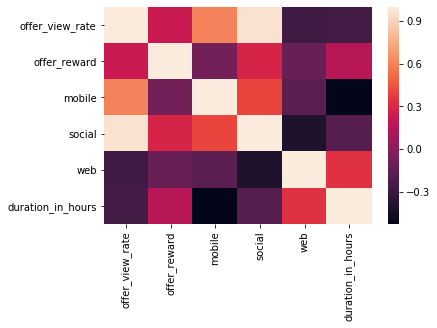

In [132]:
offer_view_rate_corr = offer_view_rate[['offer_view_rate','offer_type', 'offer_reward', 'mobile', 'social',  'web', 'duration_in_hours']].corr()

sns.heatmap(offer_view_rate_corr, 
        xticklabels=offer_view_rate_corr.columns,
        yticklabels=offer_view_rate_corr.columns)

## Here we can see that iff we are trying to reach customers, the social channel seems to be the most effective.  We are unable to determine the ffectiveness of emails in the dataset, because all offers are sent via email.  It would be interesting to have some of the same offers which are not sent via email to determine how effective this marketing channel is.

# Completion rates for all received offers

In [160]:
offer_completed_rate = get_df_performance(offer_completed_rate, 'received_count', 'completed_count', p_threshold=0.05)
offer_completed_rate = offer_completed_rate.merge(portfolio, how='left', on='offer_id').drop(['p_val', 't_stat', 'email'], axis=1).corr().round(2)
offer_completed_rate.sort_values(by='offer_completed_rate', ascending=False)


,received_count,completed_count,offer_completed_rate,offer_reward,difficulty,duration,web,social,mobile,duration_in_hours
completed_count,-0.17,1.00,1.00,-0.69,-0.50,0.24,0.28,0.31,0.44,0.24
offer_completed_rate,-0.18,1.00,1.00,-0.71,-0.48,0.25,0.30,0.30,0.42,0.25
mobile,-0.39,0.44,0.42,0.03,-0.88,-0.58,-0.14,0.49,1.00,-0.58
web,-0.29,0.28,0.30,-0.60,-0.03,0.05,1.00,-0.29,-0.14,0.05
social,-0.61,0.31,0.30,0.32,-0.36,-0.33,-0.29,1.00,0.49,-0.33
duration,0.40,0.24,0.25,-0.46,0.64,1.00,0.05,-0.33,-0.58,1.00
duration_in_hours,0.40,0.24,0.25,-0.46,0.64,1.00,0.05,-0.33,-0.58,1.00
received_count,1.00,-0.17,-0.18,0.02,0.30,0.40,-0.29,-0.61,-0.39,0.40
difficulty,0.30,-0.50,-0.48,0.06,1.00,0.64,-0.03,-0.36,-0.88,0.64
offer_reward,0.02,-0.69,-0.71,1.00,0.06,-0.46,-0.60,0.32,0.03,-0.46


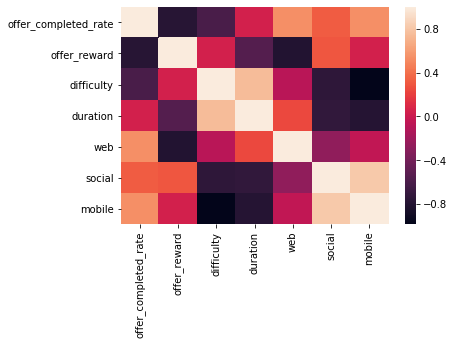

In [163]:
offer_completed_rate_corr = offer_completed_rate.drop(['received_count', 'completed_count', 'duration_in_hours'], axis=1).corr()

sns.heatmap(offer_completed_rate_corr, 
        xticklabels=offer_completed_rate_corr.columns,
        yticklabels=offer_completed_rate_corr.columns)

## It is interesting that while social offers are viewed most frequently, mobile offers are completed most frequently.  This is possibly due to users checking their phones while they wait in line to make an offer.  We can also see an expected result that the more difficult an offer is to complete, the less likely it is that the offer will be completed.    

# Completion rates of offers that have been viewed

In [135]:
offer_viewed_completed_rate.head()

,offer_id,received_count,viewed_completed_count,offer_viewed_completed_rate,offer_type
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,1323,0.17,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,4323,0.57,discount
2,2906b810c7d4411798c6938adc9daaa5,7632,2102,0.28,discount
4,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,2730,0.36,bogo
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,2106,0.27,bogo


In [136]:
offer_viewed_completed_rate = get_df_performance(
    offer_viewed_completed_rate, 'received_count', 'viewed_completed_count', p_threshold=0.05)
offer_viewed_completed_rate

,offer_id,received_count,viewed_completed_count,offer_viewed_completed_rate,offer_type,p_val,t_stat,performance
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,1323,0.17,discount,0.000,43.644,under
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,4323,0.57,discount,0.000,-30.989,over
2,2906b810c7d4411798c6938adc9daaa5,7632,2102,0.28,discount,0.000,18.992,under
4,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,2730,0.36,bogo,0.001,3.407,under
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,2106,0.27,bogo,0.000,19.262,under
7,ae264e3637204a6fb9bb56bc8210ddfd,7658,2585,0.34,bogo,0.000,7.288,under
8,f19421c1d4aa40978ebb69ca19b0e20d,7571,3505,0.46,bogo,0.000,-13.782,over
9,fafdcd668e3743c1bb461111dcafc2a4,7597,4489,0.59,discount,0.000,-35.395,over


In [137]:
offer_viewed_completed_rate.merge(
    portfolio, how='left', on='offer_id').drop(['p_val', 't_stat', 'email'], axis=1).corr()

,received_count,viewed_completed_count,offer_viewed_completed_rate,offer_reward,difficulty,duration,web,social,mobile,duration_in_hours
received_count,1.000000,-0.545041,-0.550578,0.017775,0.303096,0.396525,-0.287660,-0.610773,-0.391322,0.396525
viewed_completed_count,-0.545041,1.000000,0.999788,-0.304404,-0.512701,-0.055063,0.111864,0.776826,0.566709,-0.055063
offer_viewed_completed_rate,-0.550578,0.999788,1.000000,-0.303587,-0.509751,-0.060398,0.108685,0.779584,0.570597,-0.060398
offer_reward,0.017775,-0.304404,-0.303587,1.000000,0.063532,-0.456679,-0.600533,0.323875,0.031607,-0.456679
difficulty,0.303096,-0.512701,-0.509751,0.063532,1.000000,0.642245,-0.031906,-0.355999,-0.882729,0.642245
duration,0.396525,-0.055063,-0.060398,-0.456679,0.642245,1.000000,0.052926,-0.325396,-0.582182,1.000000
web,-0.287660,0.111864,0.108685,-0.600533,-0.031906,0.052926,1.000000,-0.292770,-0.142857,0.052926
social,-0.610773,0.776826,0.779584,0.323875,-0.355999,-0.325396,-0.292770,1.000000,0.487950,-0.325396
mobile,-0.391322,0.566709,0.570597,0.031607,-0.882729,-0.582182,-0.142857,0.487950,1.000000,-0.582182
duration_in_hours,0.396525,-0.055063,-0.060398,-0.456679,0.642245,1.000000,0.052926,-0.325396,-0.582182,1.000000


## We can see that although mobile offers are completed the most frequently, social offers are viewed and then completed most frequently.

# Completion rates for offers that have not been viewed

In [138]:
offer_completed_not_viewed_rate.columns

Index(['offer_id', 'received_count', 'completed_not_viewed_count',
       'offer_completed_not_viewed_rate', 'offer_type',
       'offer_viewed_completed_rate', 'viewed_more'],
      dtype='object')

In [139]:
offer_completed_not_viewed_rate = get_df_performance(
    offer_completed_not_viewed_rate, 'received_count', 'completed_not_viewed_count', p_threshold=0.05)
offer_completed_not_viewed_rate

,offer_id,received_count,completed_not_viewed_count,offer_completed_not_viewed_rate,offer_type,offer_viewed_completed_rate,viewed_more,p_val,t_stat,performance
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,1738,0.23,discount,0.17,False,0.0,-27.649,over
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,152,0.02,discount,0.57,True,0.0,35.822,under
2,2906b810c7d4411798c6938adc9daaa5,7632,1306,0.17,discount,0.28,True,0.0,-18.031,over
3,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,87,0.01,bogo,0.36,True,0.0,46.953,under
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,1567,0.20,bogo,0.27,True,0.0,-23.922,over
5,ae264e3637204a6fb9bb56bc8210ddfd,7658,419,0.05,bogo,0.34,True,0.0,12.609,under
6,f19421c1d4aa40978ebb69ca19b0e20d,7571,131,0.02,bogo,0.46,True,0.0,38.657,under
7,fafdcd668e3743c1bb461111dcafc2a4,7597,131,0.02,discount,0.59,True,0.0,38.771,under


In [164]:
offer_completed_not_viewed_rate = offer_completed_not_viewed_rate.merge(
    portfolio, how='left', on='offer_id').drop(['p_val', 't_stat', 'email'], axis=1)

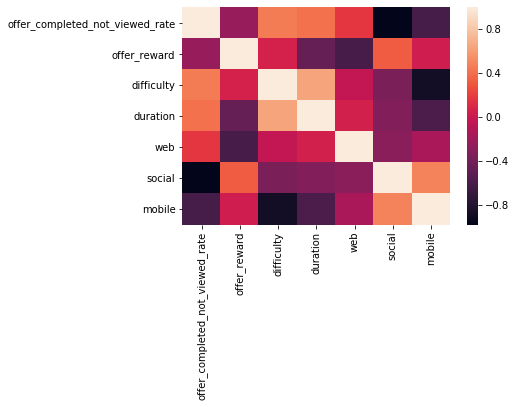

In [172]:
offer_completed_not_viewed_rate_corr = offer_completed_not_viewed_rate.drop(['received_count', 'completed_not_viewed_count',
                                                                            'duration_in_hours', 'viewed_more',
                                                                            'offer_viewed_completed_rate'], axis=1).corr()

sns.heatmap(offer_completed_not_viewed_rate_corr, 
        xticklabels=offer_completed_not_viewed_rate_corr.columns,
        yticklabels=offer_completed_not_viewed_rate_corr.columns)

## We can see that web offers are the most likely to be completed without ever being viewed.  Therefore, this is not a very good marketting channel.

# Lets examine some visualizations of how users receive, view, and complete offers as well as some spending habits of the customer base 

# Lets examine the offers that have been received by the users

In [142]:
offers_received.merge(portfolio, how='left', on='offer_id')[['email', 'mobile', 'web', 'social']].sum()

email     76277
mobile    68609
web       61001
social    45683
dtype: int64

All four channels have high counts in offers sent, with social offers being the lowest.

In [143]:
offers_received.merge(portfolio, how='left', on='offer_id').groupby('offer_type')['offer_type'].count()

offer_type
bogo             30499
discount         30543
informational    15235
Name: offer_type, dtype: int64

There are about half as many informational offers as bogo and discount offers.

In [144]:
offers_received = offers_received.merge(portfolio, how='left', on='offer_id')

offers_received[offers_received['offer_type'].isin(['bogo', 'discount'])][['difficulty', 'duration', 'offer_reward']].describe()

,difficulty,duration,offer_reward
count,61042.000000,61042.000000,61042.000000
mean,9.631434,7.253383,5.250254
std,4.449554,1.783308,2.988313
min,5.000000,5.000000,2.000000
25%,7.000000,7.000000,3.000000
50%,10.000000,7.000000,5.000000
75%,10.000000,10.000000,5.000000
max,20.000000,10.000000,10.000000


The offer dificulty is approximately normally distributed while the duration and offer rewards are left scewed. 

# Now that we have examined the dataset, lets make a machine learning model to predict how a user will respond to an offer.  If an offer is received, there are for outcomes that can occur.
# 1) The user ignores the offer and doesn't complete it
# 2) The user views the offer but does not complete it
# 3) The user views and completes the offer
# 4) The user completes the offer wihtout ever viewing it

# For this analysis, we will subset the transaction data to only include completable offers.  Informational offers will be ignored.

# By building this model, we can then predict which offer a user is most likely to view and complete and we can then suggest customized offers to our user base that will increase user interaction while also optimizing sales influenced by received offers.

In [145]:
def get_lable(row):
    '''Function to convert times to lables for machine learning
    Args:
       row (df row): drow columns ['received_time', 'viewed_time', 'completed_time']
    Returns:
        (int): class label
    '''
    if row['completed_time'] and row['viewed_time']:
        return 0
    elif row['completed_time']:
        return 1
    elif row['viewed_time']:
        return 2
    else:
        return 3

labels_dict = {0:'viewed and completed',1:'completed but not viewed',
               2:'viewed but not completed',3:'ignored'}

In [146]:
def get_lables(df):
    '''Function to create a label column with the outcome of received offers
    Args:
        df (df): df columns ['user_id, 'offer_id', 'received_id' 'received_time', 
            'viewed_time', 'completed_time']
    Returns:
        classification_df (df): df with 'class_label' for classification
    '''
    classification_df = df.copy()
    classification_df['class_label'] = classification_df.apply(get_lable, axis=1)
    
    return classification_df

# classification_df = get_lables(df)
# classification_df.columns

In [147]:
profile[profile['age']!=118].describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


In [148]:
def get_age_group(row):
    '''Function to change age into a categorical variable
    Args:
        row (df row): df row from profile
    Returns:
        age_group (str): str representing users age group
    '''
    if row['age']==118:
        age_group='age9'
    else:
        age_group = 'age'+str(int(round((row['age']-18)/10)))
        
    return age_group
        
def get_income_group(row):
    '''Function to change income group into a categorical variable
    Args:
        row (df row): df row from profile
    Returns:
        income_group (str): str representing users income_group
    '''
    if row['income'] > 0:
        income_group = 'inc'+str(int(round((row['income']-30000)/10000)))
    else:
        income_group = 'inc10'
        
    return income_group


In [149]:
def prep_users(profile):
    '''Function to prepare user profile for offer classification
    Args:
        profile (df): df with user information
    Returns:
        profile_df (Df): profile df with age , income, and gender transformed into categorical features
    '''
    profile_df = profile.drop(''.copy()
    profile_df['age_group'] = profile_df.apply(get_age_group, axis=1)
    age_dummies = pd.get_dummies(profile_df['age_group'])
    profile_df['income_group'] = profile_df.apply(get_income_group, axis=1)
    income_dummies = pd.get_dummies(profile_df['income_group'])
    gender_dummies = pd.get_dummies(profile_df['gender'])
    profile_df = pd.concat([profile_df, age_dummies, income_dummies, gender_dummies], axis=1)
    profile_df = profile_df.drop(['age','age_group', 'income', 'income_group', 'gender'], axis=1)
    
    return profile_df

# prep the user profiles for classification
profile_df = prep_users(profile)
profile_df.head()

,user_id,became_member_on,age0,age1,age2,age3,age4,age5,age6,age7,...,inc4,inc5,inc6,inc7,inc8,inc9,F,M,N,O
0,68be06ca386d4c31939f3a4f0e3dd783,1970-01-01 00:00:00.020170212,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,38fe809add3b4fcf9315a9694bb96ff5,1970-01-01 00:00:00.020180712,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,1970-01-01 00:00:00.020170509,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,a03223e636434f42ac4c3df47e8bac43,1970-01-01 00:00:00.020170804,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### While all of the information about an offer is tied to a single categorical variable, offer_id, it would be nice to have a model that is fit to the offer attributes so that we could assess how a new reward offer would affect customer bahaviors

In [150]:
def get_classification_portfolio(portfolio):
    '''Function to create feature for completable offers
    Args:
        portfolio (df): df with offer information
    Returns:
        portfolio_df (df) df with offer features
    '''
    # subset to completable offers
    portfolio_df = portfolio[portfolio['offer_type'].isin(['bogo', 'discount'])]
    # expand offer type to categorical
    offer_type_dummies = pd.get_dummies(portfolio_df['offer_type'])
    portfolio_df = pd.concat([portfolio_df, offer_type_dummies], axis=1)
    portfolio_df.drop('offer_type', axis=1, inplace=True)
    portfolio_df.drop('email', axis=1, inplace=True)
    
    return portfolio_df

#portfolio_df = get_classification_portfolio(portfolio)
#portfolio_df

In [151]:
def prep_classification_df(vc_df, v_no_c_df, c_no_v_df, received_ignored_df, profile, portfolio):
    '''Function to prepare dataset for classification
    Args:
        vc_df (df): df with offers viewed and completed
        v_no_c_df (df): df with offers viewed but not completed
        c_no_v_df (df): df with offers completed but not viewed 
        received_ignored_df (df): df with offers that were received but not viewed or completed 
        profile (df): df with user profiles
        portfolio (df): df with offers
    '''
    v_no_c_df['completed_time'] = None
    c_no_v_df['viewed_time'] = None
    received_ignored_df['viewed_time'] = None
    received_ignored_df['completed_time'] = None
    cat_dfs = []
    # cat together all received offers
    for df in [v_no_c_df, vc_df, c_no_v_df, received_ignored_df]:
        cat_dfs.append(df[['user_id', 'offer_id', 'received_id', 'received_time', 'viewed_time', 'completed_time']])
            
    df = pd.concat(cat_dfs,axis=0, ignore_index=True)
    # get classification labels for each received offer
    classification_df = get_lables(df)
    # add user features to classification df
    profile_df = prep_users(profile)
    classification_df = classification_df.merge(profile_df, how='left', on='user_id')
    # add offer features to classification df
    portfolio_df = get_classification_portfolio(portfolio)
    classification_df = classification_df.merge(portfolio_df, how='left', on='offer_id')
    # remove columns that will not be used in classification
    classification_df.drop(['user_id', 'offer_id', 'received_id', 'received_time', 'viewed_time',
       'completed_time'], axis=1, inplace=True)
    
    return classification_df

classification_df = prep_classification_df(vc_df, v_no_c_df, c_no_v_df, 
                                           received_ignored_df, profile, portfolio)

array([3, 2, 0, 1])

Text(0.5, 1.0, 'Income Group Distribution')

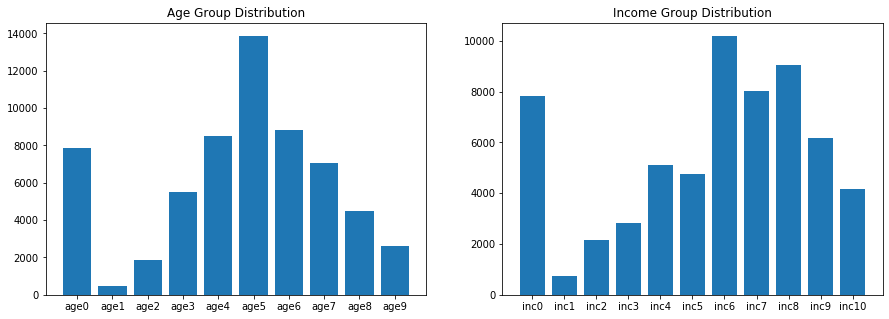

In [152]:
# lets exmine the distributions of our age groups and income groups within the data set
inc_counts = classification_df.groupby(['inc0', 'inc1', 'inc2', 'inc3', 'inc4',
       'inc5', 'inc6', 'inc7', 'inc8', 'inc9', 'inc10'])['class_label'].count().values
age_counts = classification_df.groupby(['age0', 'age1', 'age2', 'age3', 'age4', 'age5', 'age6',
       'age7', 'age8', 'age9'])['class_label'].count().values

age_groups = ['age0', 'age1', 'age2', 'age3', 'age4', 'age5', 'age6', 'age7', 'age8', 'age9']
inc_groups = ['inc0', 'inc1', 'inc2', 'inc3', 'inc4', 'inc5', 'inc6', 'inc7', 'inc8', 'inc9', 'inc10']

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
f.set_figheight(5)
f.set_figwidth(15)
ax1.bar(age_groups, age_counts)
ax1.set_title('Age Group Distribution')
ax2.bar(inc_groups, inc_counts)
ax2.set_title('Income Group Distribution')


### We can see that offer receival rates are not the same for all users.  This is likely due to marketing strategies within  the company.  Users that would typically be working class (ages 25-35, incomes $40-50K) receive significantly less offers than other user groups.  This is probably due to the fact that these are regular users and therefore, one would not expect them to visit stores more frequently and make more purchases if given offers.

In [153]:
def get_test_train_data(classification_df):
    '''Funciton to get train and test data sets and to print the distribution of labels within each
    Args:
        classification_df (df): df with data for classification
    Returns:
        X_train (2D numpy array): training features 
        X_test (2D numpy array): test features
        Y_train (2D numpy array): train labels 
        Y_test (2D numpy array): test labels
    '''
    Y = classification_df['class_label'].values
    X = classification_df.drop('class_label',axis=1).values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2, random_state=42)
    # check the distribution of labels between the test and train data
    for i in range(4):
        print(f'{labels_dict[i]:>25}- Train: {(Y_train==i).sum():>7}   Test: {(Y_test==i).sum()}')
    
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = get_test_train_data(classification_df)
print(X_train.shape, Y_train.shape)

     viewed and completed- Train:   17692   Test: 4486
 completed but not viewed- Train:    5162   Test: 1233
 viewed but not completed- Train:   18427   Test: 4554
                  ignored- Train:    7552   Test: 1936
(48833, 35) (48833,)


In [154]:
def train_evaluate_model(model_class, X_train, X_test, Y_train, Y_test):
    '''Function to train and evaluate a model using default model arguments
    Args:
        model_class (sklearn.estimator): RandomForestClassifier(), LogisticRegression(), or CategoricalNB()
        X_train
        X_test
        Y_train
        Y_test
    Returns:
        model (sklearn.estimator): trained model
    '''
    model = model_class
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    print(labels_dict)
    print(classification_report(Y_test, Y_pred))
    print(confusion_matrix(Y_test, Y_pred))
    print(f'Model Accuracy: {accuracy_score(Y_test, Y_pred)}')
    
    return model

#model = train_evaluate_model(RandomForestClassifier(), X_train, X_test, Y_train, Y_test)

In [155]:
def test_default_models(X_train, X_test, Y_train, Y_test):
    '''Function to test the default performance of three different classifiers: RandomForestClassifier,
        LogisticRegression, and SVC
    Args:
        X_train (2D numpy array): training features 
        X_test (2D numpy array): test features
        Y_train (2D numpy array): train labels 
        Y_test (2D numpy array): test labels
    Returns:
        trained_models_dict (dict): dict with trained models    
    '''
    classifier_dict = {'RandomForestClassifier':RandomForestClassifier(),
                       'LogisticRegression':LogisticRegression(max_iter=3000),
                       'CategoricalNB':CategoricalNB()}
    
    trained_models_dict ={}
    
    for classifier in classifier_dict:
        print(f'Evaluating default performance of {classifier}: ')
        model = train_evaluate_model(classifier_dict[classifier], X_train, X_test, Y_train, Y_test)
        trained_models_dict[classifier] = model
        
    return trained_models_dict
     
#trained_models_dict = test_default_models(X_train, X_test, Y_train, Y_test)


###  We can see that all of the models are performing at about a 50% accuracy for the classification task.  While this is not great, it is better than the random case of ~25%.  In choosing the best model for this task, we need to consider the different classes.  It is not imperative that we accurately classify ignored offers as sending an offer that ends up being ignored will not result in lost revinue for the company.  We can see that Categorical Naive Bayes (CNB) does the best job of classifying offers that are completed but not viewed.  It is able to successfully classify the most of these and when it errors, it tends to classify the offer as an ignored offer.  This is a good result because in either case, you probably would not end up sending the offer to the customer. However, CNB also does the worst job of correctly classifying offers that are viewed and then completed, which could end up resulting in lost revinues if used to recommend offers.  Logistic regression and RandomForest have nearly identical performance with RandomForest performing slightly better at classiying offers that are completed without ever being viewed.

## Lets see if we can get better performance from the RandomForest classifier

In [156]:
#trained_models_dict['RandomForestClassifier'].get_params()

In [157]:
def optimize_random_forest(X_train, X_test, Y_train, Y_test):
    """Function that evaluates model on test data printing f1 score for each label
    Args:
        X_test (2D boolean numpy array): test features
        Y_test ([1D int numpy array]): test labels 
    Returns:
        model (estimator): grid search cv optimized model
    """
    
    # Number of trees in random forest
    n_estimators = [4, 8, 10, 20, 40, 100,200,400,600,800,1000]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [2, 4, 6, 10,15,20,30,50,100]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    # instantiate the model
    rf_model = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_randomcv_model = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 50, 
                                   cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_randomcv_model.fit(X_train, Y_train)
    
    #make predictions on X_test
    Y_pred = rf_randomcv_model.predict(X_test)
    
    # evaluate model performance
    try:
        print(labels_dict)
        print(classification_report(Y_test, Y_pred))
        print(confusion_matrix(Y_test, Y_pred))
        print(f'Model Accuracy: {accuracy_score(Y_test, Y_pred)}')
    except Exception as e:
        print(e)
        
    return rf_randomcv_model

#rf_rand_optimized = optimize_random_forest(X_train, X_test, Y_train, Y_test)
#rf_rand_optimized.get_params()


In [2]:
def save_model(model, model_filepath):
    """Function that saves model as a pickle file
    Args:
        model (estimator): fitted sklearn estimator"
        model_filepath (str): relative file path for saving model
    Returns:
        None
    """
    # save the model to disk
    pickle.dump(model, open(model_filepath, 'wb'))

#save_model(rf_rand_optimized, 'rf_rand_optimized')